# REU Poster Figures

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy

## Useful Functions

In [2]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

In [3]:
#question: the way we define sigma here doesn't involve dx and L_filt --> should it?

def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

In [4]:
def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(so_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

In [5]:
def get_2_depths(ds,first,mid,last,sample_max,variable='TEMP'):
    interp_1=get_ds_interp(ds,first,mid,sample_max)
    interp_2=get_ds_interp(ds,mid,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    
    return filt_1,var_1,filt_2,var_2

In [6]:
def get_3_depths(ds,first,mid1,mid2,last,sample_max,variable='TEMP'):
    interp_1=get_ds_interp(ds,first,mid1,sample_max)
    interp_2=get_ds_interp(ds,mid1,mid2,sample_max)
    interp_3=get_ds_interp(ds,mid2,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    filt_3=get_ds_filt(interp_3,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    var_3=get_var(interp_3,filt_3)
    
    return filt_1,var_1,filt_2,var_2,filt_3,var_3

## Housekeeping

In [7]:
np_param=[-155,-145,30,35,0,2000]
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
na_param=[-55,-45,40,45,0,2000]
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")
so_param=[30,40,-55,-50,0,2000]
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
io_param=[90,100,-15,-10,0,2000]
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")

In [8]:
so_interp=get_ds_interp(so_ds,0,2000,3)
np_interp=get_ds_interp(np_ds,0,2000,3)
na_interp=get_ds_interp(na_ds,0,2000,3)
io_interp=get_ds_interp(io_ds,0,2000,3)

In [9]:
so_filt=get_ds_filt(so_interp,0.5,2.5,50)
np_filt=get_ds_filt(np_interp,0.5,2.5,50)
na_filt=get_ds_filt(na_interp,0.5,2.5,50)
io_filt=get_ds_filt(io_interp,0.5,2.5,50)

In [10]:
so_var=get_var(so_interp,so_filt)
np_var=get_var(np_interp,np_filt)
na_var=get_var(na_interp,na_filt)
io_var=get_var(io_interp,io_filt)

In [11]:
first,mid1,mid2,last,sample_max=0,200,1000,2000,3
so_filt_1,so_var_1,so_filt_2,so_var_2,so_filt_3,so_var_3=get_3_depths(so_ds,first,mid1,mid2,last,sample_max)
np_filt_1,np_var_1,np_filt_2,np_var_2,np_filt_3,np_var_3=get_3_depths(np_ds,first,mid1,mid2,last,sample_max)
na_filt_1,na_var_1,na_filt_2,na_var_2,na_filt_3,na_var_3=get_3_depths(na_ds,first,mid1,mid2,last,sample_max)
io_filt_1,io_var_1,io_filt_2,io_var_2,io_filt_3,io_var_3=get_3_depths(io_ds,first,mid1,mid2,last,sample_max)

## Data

#### Map of Boxes

In [161]:
np_lon,np_lat=np.average((np_param[0],np_param[1])),np.average((np_param[2],np_param[3]))
na_lon,na_lat=np.average((na_param[0],na_param[1])),np.average((na_param[2],na_param[3]))
so_lon,so_lat=np.average((so_param[0],so_param[1])),np.average((so_param[2],so_param[3]))
io_lon,io_lat=np.average((io_param[0],io_param[1])),np.average((io_param[2],io_param[3]))

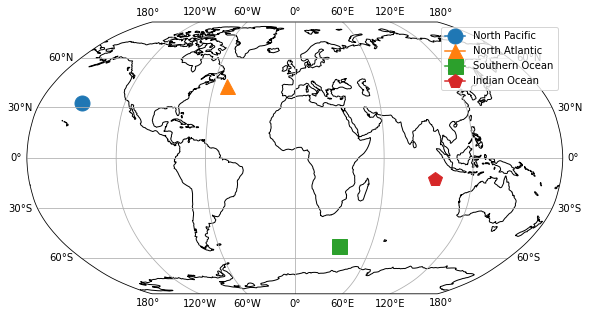

In [169]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np_lon,np_lat,transform=ccrs.PlateCarree(),label='North Pacific',marker='o',markersize=15)
plt.plot(na_lon,na_lat,transform=ccrs.PlateCarree(),label='North Atlantic',marker='^',markersize=15)
plt.plot(so_lon,so_lat,transform=ccrs.PlateCarree(),label='Southern Ocean',marker='s',markersize=15)
plt.plot(io_lon,io_lat,transform=ccrs.PlateCarree(),label='Indian Ocean',marker='p',markersize=15)
plt.legend()

In [ ]:
# plt.figure(figsize=(10,5))
# ax=plt.axes(projection=ccrs.Robinson())
# ax.set_global()
# ax.coastlines()
# ax.gridlines(draw_labels=True)
# plt.plot((np_param[0],np_param[1],np_param[1],np_param[0],np_param[0]), (np_param[2],np_param[2],np_param[3],np_param[3],np_param[2]),transform=ccrs.PlateCarree(),label='North Pacific')
# plt.plot((na_param[0],na_param[1],na_param[1],na_param[0],na_param[0]), (na_param[2],na_param[2],na_param[3],na_param[3],na_param[2]),transform=ccrs.PlateCarree(),label='North Atlantic')
# plt.plot((so_param[0],so_param[1],so_param[1],so_param[0],so_param[0]), (so_param[2],so_param[2],so_param[3],so_param[3],so_param[2]),transform=ccrs.PlateCarree(),label='Southern Ocean')
# plt.plot((io_param[0],io_param[1],io_param[1],io_param[0],io_param[0]), (io_param[2],io_param[2],io_param[3],io_param[3],io_param[2]),transform=ccrs.PlateCarree(),label='Indian Ocean')
# plt.legend()
# plt.title("Map of four selected regions \n");

#### All Boxes Results

In [15]:
np_nmi=get_ds_interp(np_ds,300,2000,3)
na_nmi=get_ds_interp(na_ds,300,2000,3)
so_nmi=get_ds_interp(so_ds,300,2000,3)
io_nmi=get_ds_interp(io_ds,300,2000,3)

np_nmf=get_ds_filt(np_nmi,0.5,2.5,50)
na_nmf=get_ds_filt(na_nmi,0.5,2.5,50)
so_nmf=get_ds_filt(so_nmi,0.5,2.5,50)
io_nmf=get_ds_filt(io_nmi,0.5,2.5,50)

np_nmv=get_var(np_nmi,np_nmf)
na_nmv=get_var(na_nmi,na_nmf)
so_nmv=get_var(so_nmi,so_nmf)
io_nmv=get_var(io_nmi,io_nmf)

In [64]:
np_interp.N_PROF_NEW.attrs.update({'long_name':'Relative Profile Number'})
na_interp.N_PROF_NEW.attrs.update({'long_name':'Relative Profile Number'})
so_interp.N_PROF_NEW.attrs.update({'long_name':'Relative Profile Number'})
io_interp.N_PROF_NEW.attrs.update({'long_name':'Relative Profile Number'})

np_interp.TEMP.attrs.update({'long_name':'Temperature','units':'°C'})
na_interp.TEMP.attrs.update({'long_name':'Temperature','units':'°C'})
so_interp.TEMP.attrs.update({'long_name':'Temperature','units':'°C'})
io_interp.TEMP.attrs.update({'long_name':'Temperature','units':'°C'})

np_interp.PRES_INTERPOLATED.attrs.update({'long_name':'Interpolated Pressure','units':'db'})
na_interp.PRES_INTERPOLATED.attrs.update({'long_name':'Interpolated Pressure','units':'db'})
so_interp.PRES_INTERPOLATED.attrs.update({'long_name':'Interpolated Pressure','units':'db'})
io_interp.PRES_INTERPOLATED.attrs.update({'long_name':'Interpolated Pressure','units':'db'})

/tmp/ipykernel_42664/4084546876.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(xs[n],ys[n],'.-',label=titles[n],marker=shapes[n])


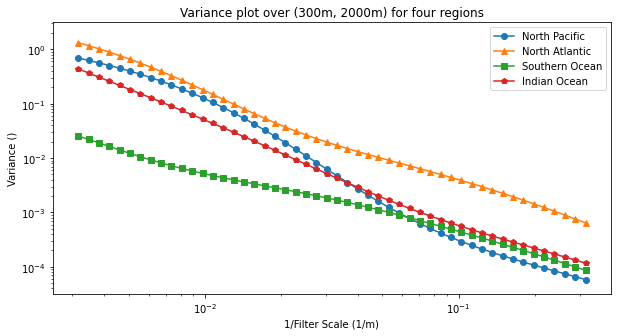

In [171]:
plt.figure(figsize=(10,5))
xs=[1/np_nmf.FILT_SCALE,1/na_nmf.FILT_SCALE,1/so_nmf.FILT_SCALE,1/io_nmf.FILT_SCALE]
ys=[np_nmv,na_nmv,so_nmv,io_nmv]
titles=['North Pacific','North Atlantic','Southern Ocean','Indian Ocean']
shapes=['o','^','s','p']

for n in range(0,4):
    plt.plot(xs[n],ys[n],'.-',label=titles[n],marker=shapes[n])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("1/Filter Scale (1/m)")
    plt.ylabel("Variance ()")
    plt.ylim(10**-4.5,10**0.5)
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.legend()
plt.title("Variance plot over (300m, 2000m) for four regions");

#### Methods Flowchart

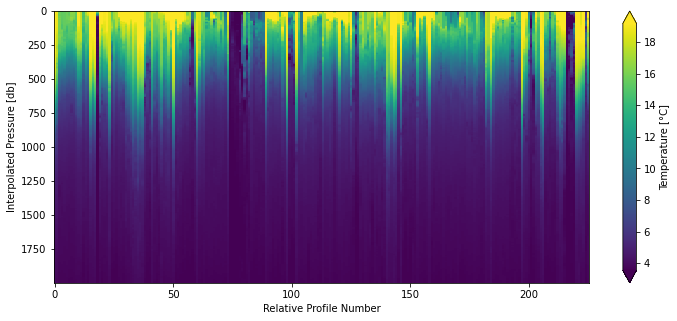

In [67]:
plt.figure(figsize=(12,5))
na_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

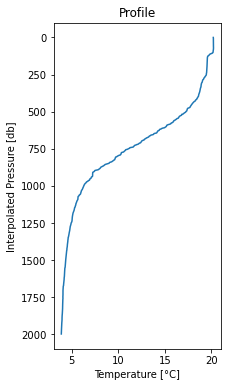

In [85]:
plt.figure(figsize=(3,6))
profile=na_interp.TEMP.isel(N_PROF=0)
profile.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('Profile');

In [ ]:
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})

In [113]:
filts=np.zeros((profile.shape[0],3))

for n,sig in enumerate([300,50,20]):
    filts[:,n]=filter.gaussian_filter1d(profile,sigma=sig,mode='nearest')
filts.shape
#filts_da=xr.DataArray(filt_300,dims=['PRES_INTERPOLATED','FILT_SCALE'],coords={'PRES_INTERPOLATED':profile.PRES_INTERPOLATED,'FILT_SCALE':[300,50,20]})

(1000, 3)

#### Variance Plots

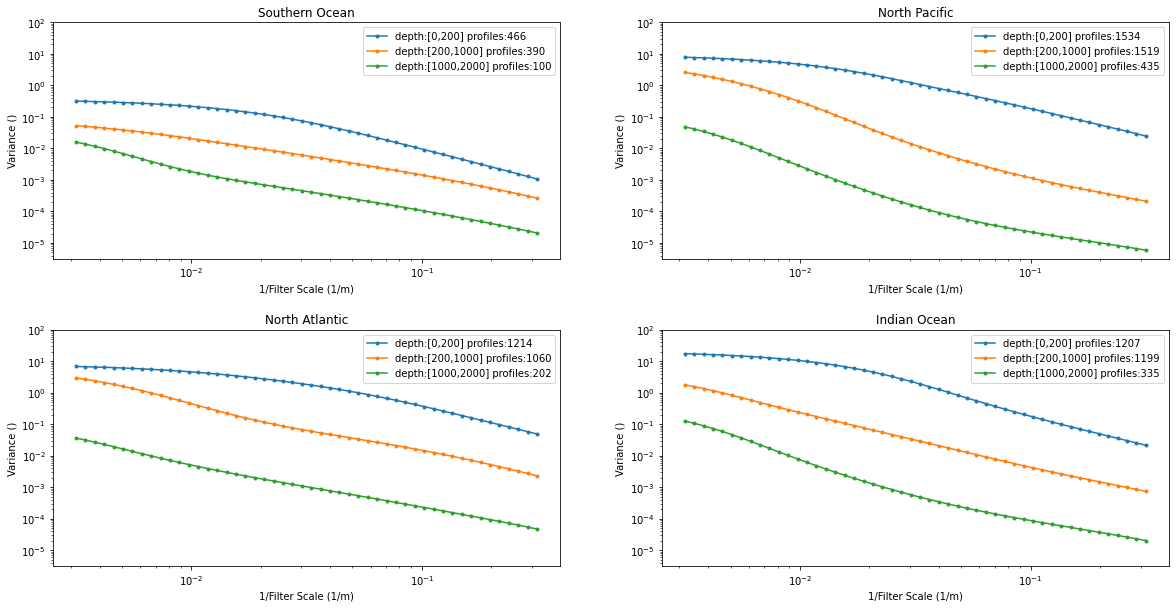

In [118]:
plt.figure(figsize=(20,10))
x1s=[1/so_filt_1.FILT_SCALE,1/np_filt_1.FILT_SCALE,1/na_filt_1.FILT_SCALE,1/io_filt_1.FILT_SCALE]
x2s=[1/so_filt_2.FILT_SCALE,1/np_filt_2.FILT_SCALE,1/na_filt_2.FILT_SCALE,1/io_filt_2.FILT_SCALE]
x3s=[1/so_filt_3.FILT_SCALE,1/np_filt_3.FILT_SCALE,1/na_filt_3.FILT_SCALE,1/io_filt_3.FILT_SCALE]
y1s=[so_var_1,np_var_1,na_var_1,io_var_1]
y2s=[so_var_2,np_var_2,na_var_2,io_var_2]
y3s=[so_var_3,np_var_3,na_var_3,io_var_3]
label1=[so_filt_1.N_PROF.shape[0],np_filt_1.N_PROF.shape[0],na_filt_1.N_PROF.shape[0],io_filt_1.N_PROF.shape[0]]
label2=[so_filt_2.N_PROF.shape[0],np_filt_2.N_PROF.shape[0],na_filt_2.N_PROF.shape[0],io_filt_2.N_PROF.shape[0]]
label3=[so_filt_3.N_PROF.shape[0],np_filt_3.N_PROF.shape[0],na_filt_3.N_PROF.shape[0],io_filt_3.N_PROF.shape[0]]
titles=['Southern Ocean','North Pacific','North Atlantic','Indian Ocean']

for n in range(0,4):
    plt.subplot(2,2,n+1)
    plt.plot(x1s[n],y1s[n],'.-',label='depth:[{},{}] profiles:{}'.format(first,mid1,label1[n]))
    plt.plot(x2s[n],y2s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid1,mid2,label2[n]))
    plt.plot(x3s[n],y3s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid2,last,label3[n]))
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("1/Filter Scale (1/m)")
    plt.ylabel("Variance ()")
    plt.ylim(10**-5.5,10**2)
    plt.title(titles[n])

plt.subplots_adjust(hspace=0.3,wspace=0.2)